# Finding the Right Clustering Method

In the previous section, we primarily stuck with the use of KMeans as our method for clustering. However, after trying to identify the most optimal number of clusters in our dataset, we quickly realized that KMeans has a flaw... It works really poorly with our type of data. In these sets of code, the goal is to find a clustering method that works the best in identifying separate clusters in our textual dataset.

We have a two pronged goal: (1) Find a clustering method that works well with text embeddings. (2) Find the most optimal number of clusters. For this notebook, we will emphasize on only 2 specific design topics to see if it works.

These are some of the following clustering algorithms that may work well for us.
 
1. **K-Means Clustering**: This is a popular choice for clustering when the number of clusters is known or can be estimated (this is not the case in our domain). It could potentially work well with high-dimensional data like word embeddings. However, it assumes that clusters are spherical and equally sized, which might not be the case with text data.

2. **Hierarchical Clustering**: This method builds a hierarchy of clusters either in a bottom-up (agglomerative) or top-down (divisive) approach. It's useful when you do not know the number of clusters in advance, and it allows you to inspect the dendrogram to decide on the number of clusters.

3. **DBSCAN (Density-Based Spatial Clustering of Applications with Noise)**: This algorithm groups together points that are closely packed together and marks as outliers points that lie alone in low-density regions. It can find arbitrarily shaped clusters and doesn't require you to specify the number of clusters beforehand.

4. **Gaussian Mixture Models (GMM)**: GMM is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. GMM can accommodate clusters that have different sizes and correlation structures within them.

5. **Spectral Clustering**: This technique uses the eigenvalues of a similarity matrix to reduce dimensionality before clustering in fewer dimensions. It can be effective when the structure of the individual clusters is highly non-convex, or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster, such as in the case of clusters with "manifold" shapes.

Here we plan to try all of them. We will take the following steps to do so.

1. **Feature Extraction**: Convert sentences into word embeddings using SentenceTransformers.

2. **Dimensionality Reduction**: Dimensionally reduce the word embeddings using PCA (retaining 80%-95% variance).

3. **Clustering**: Apply a clustering algorithm suitable for your data. We will sweep across all the clustering algorithm.

4. **Evaluation**: Evaluate the efficacy of this using silhouette score, Davies-Bouldin index, or Calinski-Harabasz index to judge the quality of the clusters.

Note, some of the scores may not be that good. Plausible explanations:

1. **Quality of Embeddings**: The embeddings might not capture the differences between authors effectively. You could try using different embedding models or fine-tuning the existing model on a corpus that is more representative of your data.

2. **Clusterability of Data**: It's possible that the data is not naturally clusterable, at least not in a way that the algorithms can detect. This could be because the writing styles of the different authors are very similar, or the sentences are too short to provide enough stylistic features.

3. **Noise and Outliers**: If your dataset contains noise or outliers, it can affect the clustering quality. Preprocessing steps to remove or mitigate the impact of outliers might be necessary.


In [1]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import pairwise_distances_argmin_min

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')

## Milk Froth

In [3]:
csv_files = [
    'data/ablation_tempTopP_froth.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)


In [4]:
# Initialize an empty list to store all embeddings
all_embeddings = []

# Iterate over each column's embeddings and extend the all_embeddings list
for embeddings in column_embeddings.values():
    all_embeddings.extend(embeddings)

# Convert the list of all embeddings into a NumPy array
all_embeddings_array = np.array(all_embeddings)

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change 

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Wi

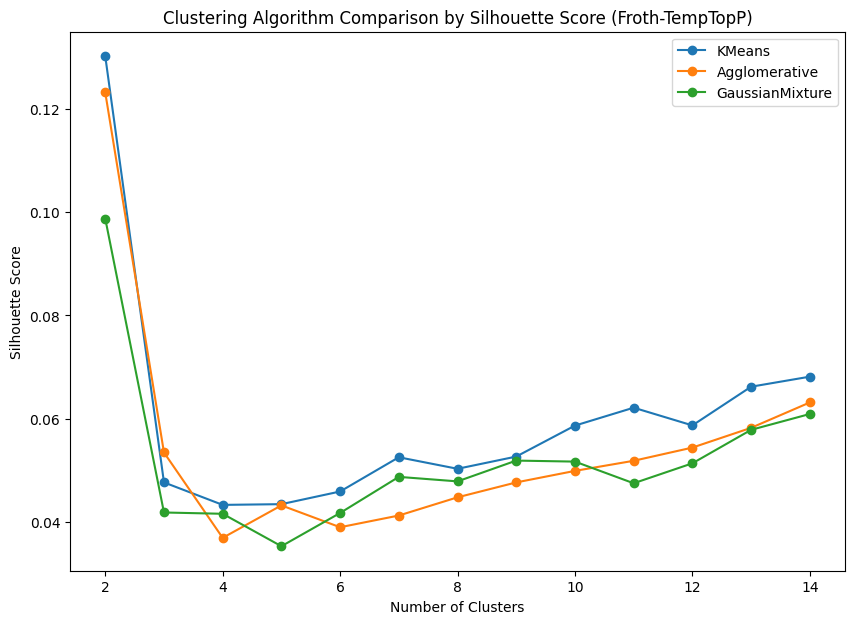

In [5]:
# Define a range of cluster numbers to evaluate
cluster_range = range(2, 15)

# Define a dictionary to store silhouette scores for each algorithm
silhouette_scores = {
    'KMeans': [],
    'Agglomerative': [],
    'GaussianMixture': []
}

# Evaluate KMeans, Agglomerative Clustering, and Gaussian Mixture Models
for n_clusters in cluster_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=3)
    kmeans_labels = kmeans.fit_predict(all_embeddings_array)
    silhouette_scores['KMeans'].append(silhouette_score(all_embeddings_array, kmeans_labels))
    
    # Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative_labels = agglomerative.fit_predict(all_embeddings_array)
    silhouette_scores['Agglomerative'].append(silhouette_score(all_embeddings_array, agglomerative_labels))
    
    # Gaussian Mixture Models
    gmm = GaussianMixture(n_components=n_clusters, random_state=3)
    gmm_labels = gmm.fit_predict(all_embeddings_array)
    silhouette_scores['GaussianMixture'].append(silhouette_score(all_embeddings_array, gmm_labels))

# Plotting the silhouette scores for each algorithm
plt.figure(figsize=(10, 7))
for algorithm, scores in silhouette_scores.items():
    plt.plot(cluster_range, scores, marker='o', label=algorithm)

# change the topic each time you run this.
plt.title('Clustering Algorithm Comparison by Silhouette Score (Froth-TempTopP)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Cluster 0: ['TopP=1|Temperature=1', 'TopP=0.5|Temperature=2', 'Human-50-v1', 'Human-50-v2']
Cluster 1: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-v1', 'Human-50-v2']


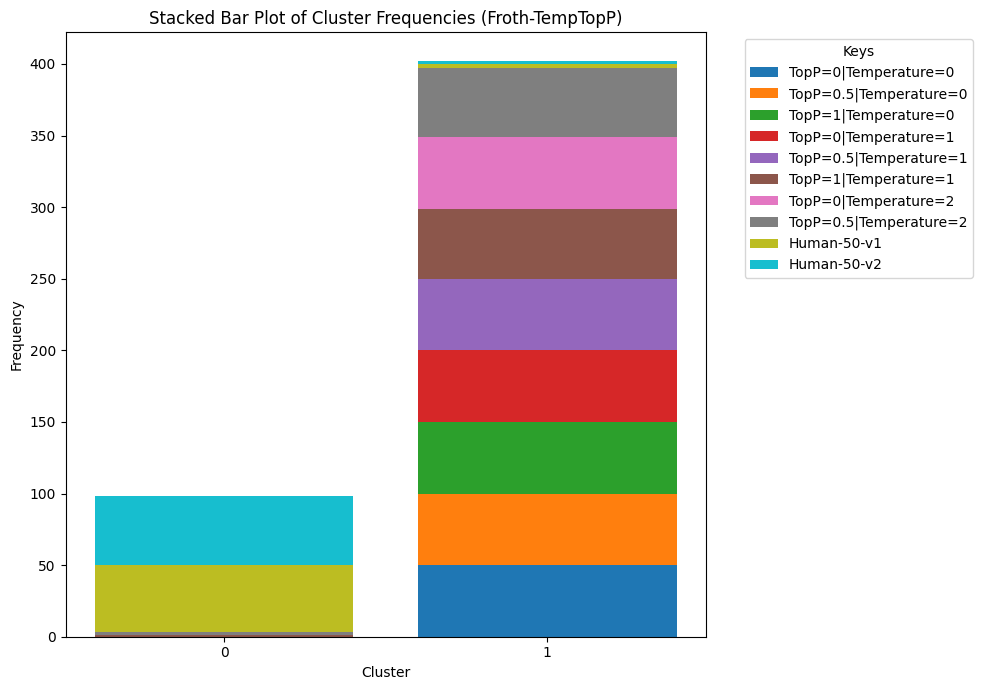

In [6]:
# List of CSV files
csv_files = [
    'data/ablation_tempTopP_froth.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)
        
# Flatten the embeddings into a single list and keep track of their column associations
all_embeddings = []
column_associations = []

for column, embeddings_list in column_embeddings.items():
    all_embeddings.extend(embeddings_list)
    column_associations.extend([column] * len(embeddings_list))

# Convert the list of embeddings into a NumPy array for clustering
# 50 solutions * 10 parameters (rows)
# 384 embeddings for each solution (columns)
all_embeddings_array = np.array(all_embeddings)

# Perform clustering
# Perform clustering on the embeddings
n_clusters = 2  # Set the number of clusters you want
kmeans = KMeans(n_clusters=n_clusters, random_state=3)
cluster_labels = kmeans.fit_predict(all_embeddings_array)

# Now, let's associate the cluster labels with their respective columns
clustered_embeddings = {
    'embeddings': all_embeddings,
    'columns': column_associations,
    'cluster_labels': cluster_labels.tolist()
}

# To analyze the clusters, let's see which columns are present in each cluster
cluster_column_associations = {i: [] for i in range(n_clusters)}

for i, label in enumerate(clustered_embeddings['cluster_labels']):
    column = clustered_embeddings['columns'][i]
    if column not in cluster_column_associations[label]:
        cluster_column_associations[label].append(column)

# Print out the column associations for each cluster
for cluster, columns in cluster_column_associations.items():
    print(f"Cluster {cluster}: {columns}")

# Optionally, you can create a DataFrame for better visualization and analysis
df_cluster_analysis = pd.DataFrame({
    'Embedding': clustered_embeddings['embeddings'],
    'Column': clustered_embeddings['columns'],
    'ClusterLabel': clustered_embeddings['cluster_labels']
})

# Count the occurrences of each column in each cluster
# we use a counter to maximize the efficiency of this process
cluster_column_counts = {}
for label, column in zip(clustered_embeddings['cluster_labels'], clustered_embeddings['columns']):
    if label not in cluster_column_counts:
        cluster_column_counts[label] = Counter()
    cluster_column_counts[label][column] += 1

# Prepare data for the stacked bar chart
cluster_bars = {}
for cluster, counts in cluster_column_counts.items():
    for column, count in counts.items():
        if column not in cluster_bars:
            cluster_bars[column] = [0] * len(cluster_column_counts)  # Initialize list for each column
        cluster_bars[column][cluster] = count
    
# Prepare the data for plotting
clusters = range(len(next(iter(cluster_bars.values()))))  # Assuming all lists are the same length
keys = cluster_bars.keys()
bottoms = [0] * len(clusters)

# Plot the stacked bar chart
plt.figure(figsize=(10, 7))  # Adjust the size as needed

for key in keys:
    values = cluster_bars[key]
    plt.bar(clusters, values, bottom=bottoms, label=key)
    bottoms = [sum(x) for x in zip(bottoms, values)]

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Stacked Bar Plot of Cluster Frequencies (Froth-TempTopP)')
plt.xticks(clusters, [i for i in clusters])
plt.legend(title='Keys', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [7]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='ClusterLabel', hover_data=['Column'], title='2D Visualization of Clustered Embeddings (Froth-TempTopP)')

# Customize the layout
fig.update_layout(
    coloraxis_colorbar=dict(title='Cluster Label'),
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2'
)

# Show the plot
fig.show()

In [8]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Define a color mapping with bold colors for 'Human-50-2v' and 'Human-50-1v', and neutral colors for others
unique_columns = df_embeddings_2d['Column'].unique()
color_mapping = {column: 'lightgrey' for column in unique_columns}  # Start with all neutral colors
color_mapping['Human-50-v1'] = 'blue'  # Assign a bold color for 'Human-50-2v'
color_mapping['Human-50-v2'] = 'red'   # Assign a bold color for 'Human-50-1v'

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='Column', hover_data=['Column', 'ClusterLabel'], title='2D Visualization of Embeddings Colored by Column (Froth-TempTopP)', color_discrete_map=color_mapping)

# Customize the layout
fig.update_layout(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Column'
)

# Show the plot
fig.show()

## Exercise

In [9]:
csv_files = [
    'data/ablation_tempTopP_exercise.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)

In [10]:
# Initialize an empty list to store all embeddings
all_embeddings = []

# Iterate over each column's embeddings and extend the all_embeddings list
for embeddings in column_embeddings.values():
    all_embeddings.extend(embeddings)

# Convert the list of all embeddings into a NumPy array
all_embeddings_array = np.array(all_embeddings)

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

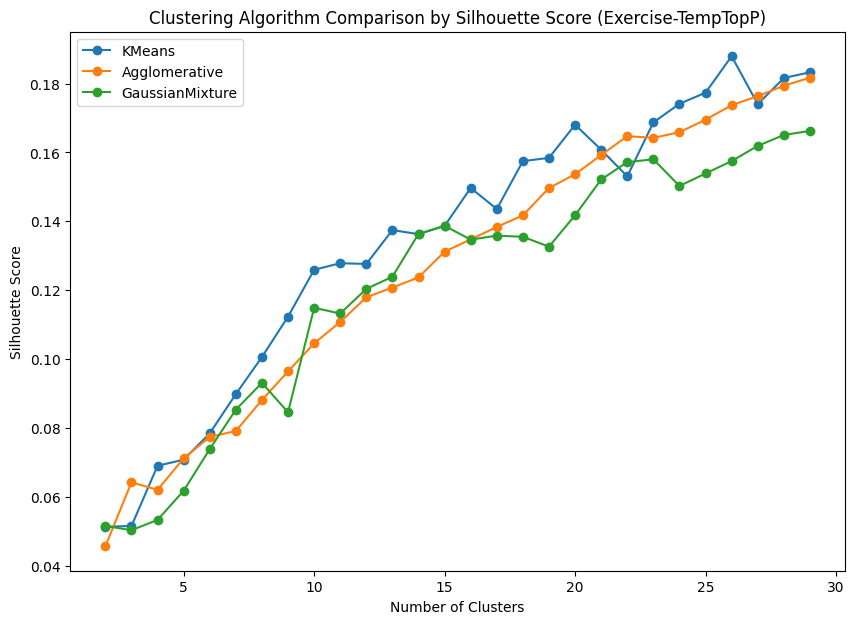

In [11]:
# Define a range of cluster numbers to evaluate
cluster_range = range(2, 30)

# Define a dictionary to store silhouette scores for each algorithm
silhouette_scores = {
    'KMeans': [],
    'Agglomerative': [],
    'GaussianMixture': []
}

# Evaluate KMeans, Agglomerative Clustering, and Gaussian Mixture Models
for n_clusters in cluster_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=3)
    kmeans_labels = kmeans.fit_predict(all_embeddings_array)
    silhouette_scores['KMeans'].append(silhouette_score(all_embeddings_array, kmeans_labels))
    
    # Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative_labels = agglomerative.fit_predict(all_embeddings_array)
    silhouette_scores['Agglomerative'].append(silhouette_score(all_embeddings_array, agglomerative_labels))
    
    # Gaussian Mixture Models
    gmm = GaussianMixture(n_components=n_clusters, random_state=3)
    gmm_labels = gmm.fit_predict(all_embeddings_array)
    silhouette_scores['GaussianMixture'].append(silhouette_score(all_embeddings_array, gmm_labels))

# Plotting the silhouette scores for each algorithm
plt.figure(figsize=(10, 7))
for algorithm, scores in silhouette_scores.items():
    plt.plot(cluster_range, scores, marker='o', label=algorithm)

# change the topic each time you run this.
plt.title('Clustering Algorithm Comparison by Silhouette Score (Exercise-TempTopP)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Cluster 0: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-1v', 'Human-50-2v']
Cluster 1: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2']
Cluster 2: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-1v', 'Human-50-2v']
Cluster 3: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-2v']
Cluster 4: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0',

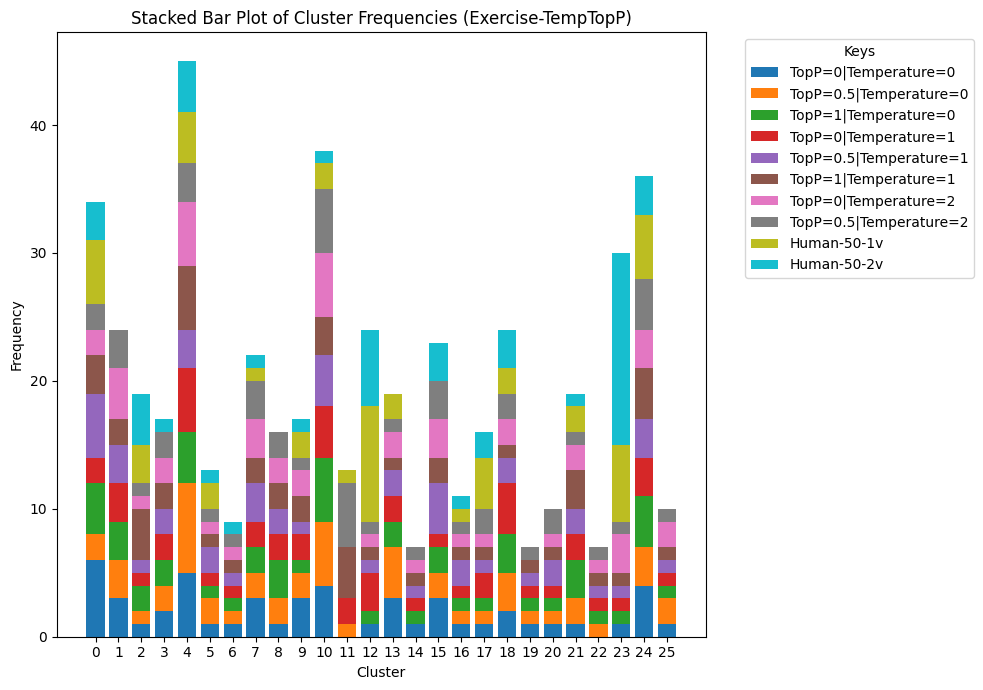

In [12]:
# List of CSV files
csv_files = [
    'data/ablation_tempTopP_exercise.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)
        
# Flatten the embeddings into a single list and keep track of their column associations
all_embeddings = []
column_associations = []

for column, embeddings_list in column_embeddings.items():
    all_embeddings.extend(embeddings_list)
    column_associations.extend([column] * len(embeddings_list))

# Convert the list of embeddings into a NumPy array for clustering
# 50 solutions * 10 parameters (rows)
# 384 embeddings for each solution (columns)
all_embeddings_array = np.array(all_embeddings)

# Perform clustering
# Perform clustering on the embeddings
n_clusters = 26  # Set the number of clusters you want
kmeans = KMeans(n_clusters=n_clusters, random_state=3)
cluster_labels = kmeans.fit_predict(all_embeddings_array)

# Now, let's associate the cluster labels with their respective columns
clustered_embeddings = {
    'embeddings': all_embeddings,
    'columns': column_associations,
    'cluster_labels': cluster_labels.tolist()
}

# To analyze the clusters, let's see which columns are present in each cluster
cluster_column_associations = {i: [] for i in range(n_clusters)}

for i, label in enumerate(clustered_embeddings['cluster_labels']):
    column = clustered_embeddings['columns'][i]
    if column not in cluster_column_associations[label]:
        cluster_column_associations[label].append(column)

# Print out the column associations for each cluster
for cluster, columns in cluster_column_associations.items():
    print(f"Cluster {cluster}: {columns}")

# Optionally, you can create a DataFrame for better visualization and analysis
df_cluster_analysis = pd.DataFrame({
    'Embedding': clustered_embeddings['embeddings'],
    'Column': clustered_embeddings['columns'],
    'ClusterLabel': clustered_embeddings['cluster_labels']
})

# Count the occurrences of each column in each cluster
# we use a counter to maximize the efficiency of this process
cluster_column_counts = {}
for label, column in zip(clustered_embeddings['cluster_labels'], clustered_embeddings['columns']):
    if label not in cluster_column_counts:
        cluster_column_counts[label] = Counter()
    cluster_column_counts[label][column] += 1

# Prepare data for the stacked bar chart
cluster_bars = {}
for cluster, counts in cluster_column_counts.items():
    for column, count in counts.items():
        if column not in cluster_bars:
            cluster_bars[column] = [0] * len(cluster_column_counts)  # Initialize list for each column
        cluster_bars[column][cluster] = count
    
# Prepare the data for plotting
clusters = range(len(next(iter(cluster_bars.values()))))  # Assuming all lists are the same length
keys = cluster_bars.keys()
bottoms = [0] * len(clusters)

# Plot the stacked bar chart
plt.figure(figsize=(10, 7))  # Adjust the size as needed

for key in keys:
    values = cluster_bars[key]
    plt.bar(clusters, values, bottom=bottoms, label=key)
    bottoms = [sum(x) for x in zip(bottoms, values)]

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Stacked Bar Plot of Cluster Frequencies (Exercise-TempTopP)')
plt.xticks(clusters, [i for i in clusters])
plt.legend(title='Keys', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='ClusterLabel', hover_data=['Column'], title='2D Visualization of Clustered Embeddings (Exercise-TempTopP)')

# Customize the layout
fig.update_layout(
    coloraxis_colorbar=dict(title='Cluster Label'),
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2'
)

# Show the plot
fig.show()

In [14]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Define a color mapping with bold colors for 'Human-50-2v' and 'Human-50-1v', and neutral colors for others
unique_columns = df_embeddings_2d['Column'].unique()
color_mapping = {column: 'lightgrey' for column in unique_columns}  # Start with all neutral colors
color_mapping['Human-50-1v'] = 'blue'  # Assign a bold color for 'Human-50-2v'
color_mapping['Human-50-2v'] = 'red'   # Assign a bold color for 'Human-50-1v'

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='Column', hover_data=['Column', 'ClusterLabel'], title='2D Visualization of Embeddings Colored by Column (Exercise-TempTopP)', color_discrete_map=color_mapping)

# Customize the layout
fig.update_layout(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Column'
)

# Show the plot
fig.show()

## Time

In [15]:
csv_files = [
    'data/ablation_tempTopP_time.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)

In [16]:
# Initialize an empty list to store all embeddings
all_embeddings = []

# Iterate over each column's embeddings and extend the all_embeddings list
for embeddings in column_embeddings.values():
    all_embeddings.extend(embeddings)

# Convert the list of all embeddings into a NumPy array
all_embeddings_array = np.array(all_embeddings)

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

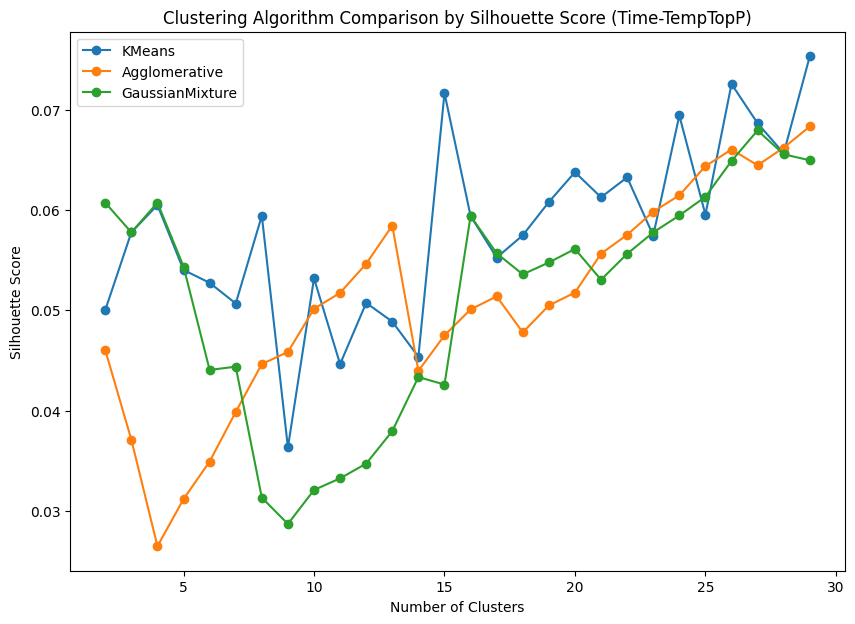

In [17]:
# Define a range of cluster numbers to evaluate
cluster_range = range(2, 30)

# Define a dictionary to store silhouette scores for each algorithm
silhouette_scores = {
    'KMeans': [],
    'Agglomerative': [],
    'GaussianMixture': []
}

# Evaluate KMeans, Agglomerative Clustering, and Gaussian Mixture Models
for n_clusters in cluster_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=3)
    kmeans_labels = kmeans.fit_predict(all_embeddings_array)
    silhouette_scores['KMeans'].append(silhouette_score(all_embeddings_array, kmeans_labels))
    
    # Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative_labels = agglomerative.fit_predict(all_embeddings_array)
    silhouette_scores['Agglomerative'].append(silhouette_score(all_embeddings_array, agglomerative_labels))
    
    # Gaussian Mixture Models
    gmm = GaussianMixture(n_components=n_clusters, random_state=3)
    gmm_labels = gmm.fit_predict(all_embeddings_array)
    silhouette_scores['GaussianMixture'].append(silhouette_score(all_embeddings_array, gmm_labels))

# Plotting the silhouette scores for each algorithm
plt.figure(figsize=(10, 7))
for algorithm, scores in silhouette_scores.items():
    plt.plot(cluster_range, scores, marker='o', label=algorithm)

# change the topic each time you run this.
plt.title('Clustering Algorithm Comparison by Silhouette Score (Time-TempTopP)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Cluster 0: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-2v']
Cluster 1: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-1v', 'Human-50-2v']
Cluster 2: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2']
Cluster 3: ['TopP=0|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-1v', 'Human-50-2v']
Cluster 4: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', '

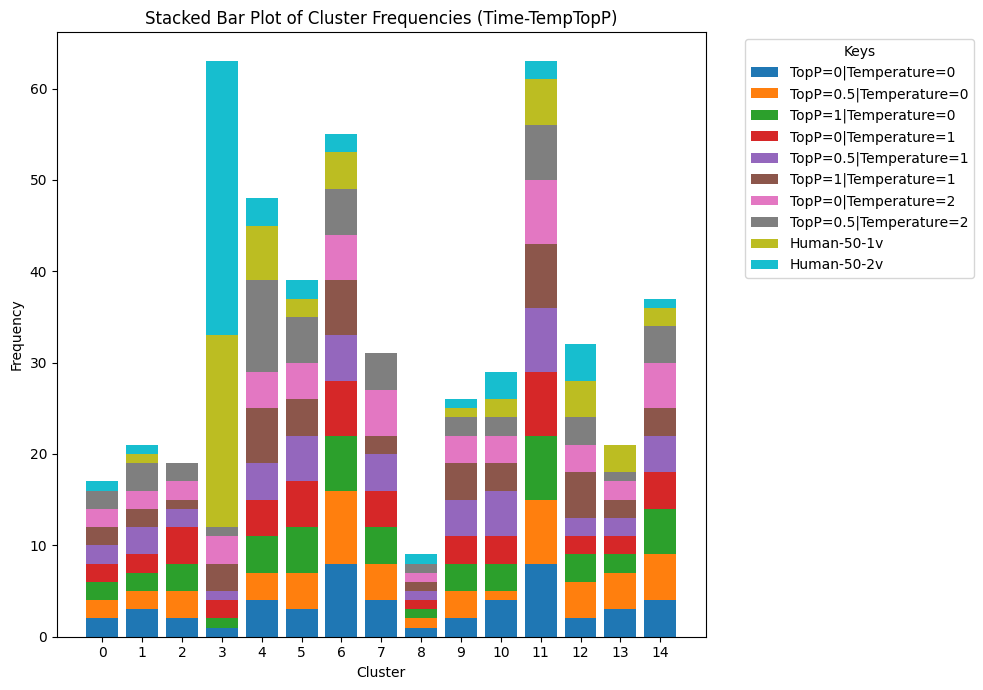

In [18]:
# List of CSV files
csv_files = [
    'data/ablation_tempTopP_exercise.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)
        
# Flatten the embeddings into a single list and keep track of their column associations
all_embeddings = []
column_associations = []

for column, embeddings_list in column_embeddings.items():
    all_embeddings.extend(embeddings_list)
    column_associations.extend([column] * len(embeddings_list))

# Convert the list of embeddings into a NumPy array for clustering
# 50 solutions * 10 parameters (rows)
# 384 embeddings for each solution (columns)
all_embeddings_array = np.array(all_embeddings)

# Perform clustering
# Perform clustering on the embeddings
n_clusters = 15  # Set the number of clusters you want
kmeans = KMeans(n_clusters=n_clusters, random_state=3)
cluster_labels = kmeans.fit_predict(all_embeddings_array)

# Now, let's associate the cluster labels with their respective columns
clustered_embeddings = {
    'embeddings': all_embeddings,
    'columns': column_associations,
    'cluster_labels': cluster_labels.tolist()
}

# To analyze the clusters, let's see which columns are present in each cluster
cluster_column_associations = {i: [] for i in range(n_clusters)}

for i, label in enumerate(clustered_embeddings['cluster_labels']):
    column = clustered_embeddings['columns'][i]
    if column not in cluster_column_associations[label]:
        cluster_column_associations[label].append(column)

# Print out the column associations for each cluster
for cluster, columns in cluster_column_associations.items():
    print(f"Cluster {cluster}: {columns}")

# Optionally, you can create a DataFrame for better visualization and analysis
df_cluster_analysis = pd.DataFrame({
    'Embedding': clustered_embeddings['embeddings'],
    'Column': clustered_embeddings['columns'],
    'ClusterLabel': clustered_embeddings['cluster_labels']
})

# Count the occurrences of each column in each cluster
# we use a counter to maximize the efficiency of this process
cluster_column_counts = {}
for label, column in zip(clustered_embeddings['cluster_labels'], clustered_embeddings['columns']):
    if label not in cluster_column_counts:
        cluster_column_counts[label] = Counter()
    cluster_column_counts[label][column] += 1

# Prepare data for the stacked bar chart
cluster_bars = {}
for cluster, counts in cluster_column_counts.items():
    for column, count in counts.items():
        if column not in cluster_bars:
            cluster_bars[column] = [0] * len(cluster_column_counts)  # Initialize list for each column
        cluster_bars[column][cluster] = count
    
# Prepare the data for plotting
clusters = range(len(next(iter(cluster_bars.values()))))  # Assuming all lists are the same length
keys = cluster_bars.keys()
bottoms = [0] * len(clusters)

# Plot the stacked bar chart
plt.figure(figsize=(10, 7))  # Adjust the size as needed

for key in keys:
    values = cluster_bars[key]
    plt.bar(clusters, values, bottom=bottoms, label=key)
    bottoms = [sum(x) for x in zip(bottoms, values)]

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Stacked Bar Plot of Cluster Frequencies (Time-TempTopP)')
plt.xticks(clusters, [i for i in clusters])
plt.legend(title='Keys', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

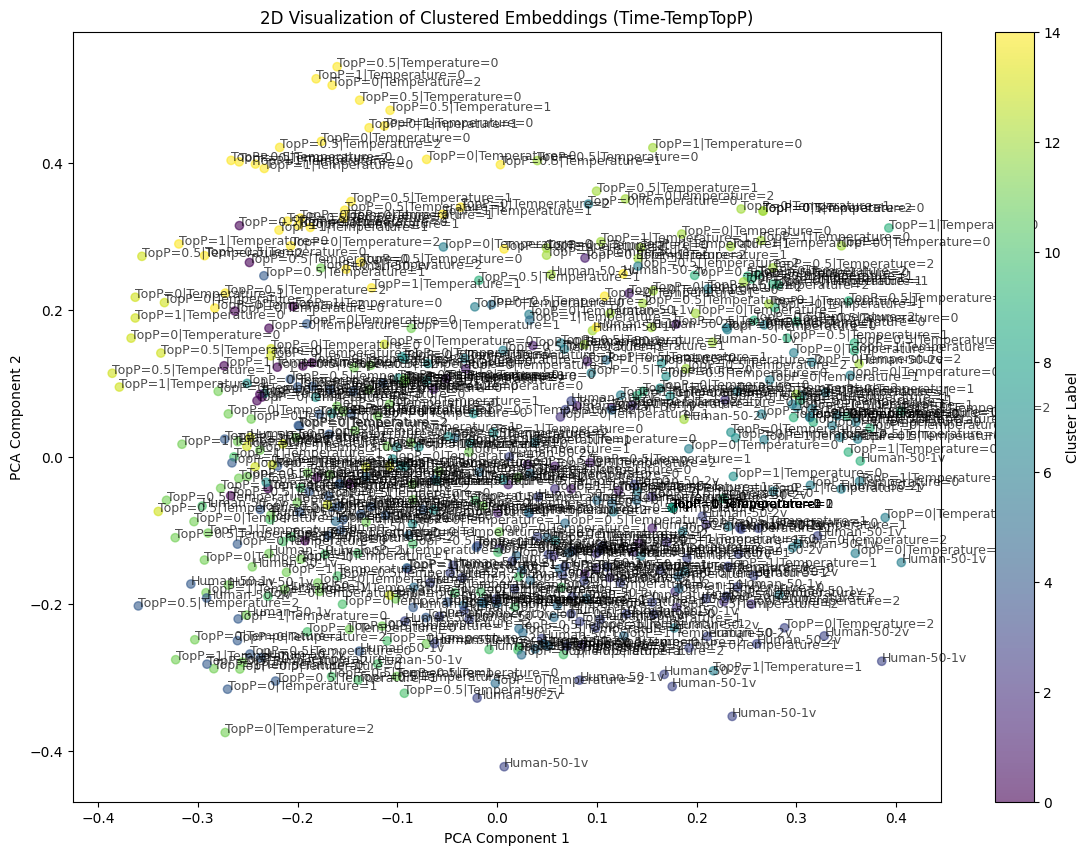

In [19]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a scatter plot of the reduced data
plt.figure(figsize=(14, 10))
scatter = plt.scatter(reduced_embeddings_2d[:, 0], reduced_embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)

# Annotate the points with their corresponding column names
for i, column_name in enumerate(column_associations):
    plt.annotate(column_name, (reduced_embeddings_2d[i, 0], reduced_embeddings_2d[i, 1]), fontsize=9, alpha=0.7)

# Add a color bar for the clusters
plt.colorbar(scatter, label='Cluster Label')

# Set the title and labels
plt.title('2D Visualization of Clustered Embeddings (Time-TempTopP)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

# Show the plot
plt.show()

In [20]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='ClusterLabel', hover_data=['Column'], title='2D Visualization of Clustered Embeddings (Time-TempTopP)')

# Customize the layout
fig.update_layout(
    coloraxis_colorbar=dict(title='Cluster Label'),
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2'
)

# Show the plot
fig.show()

In [21]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Define a color mapping with bold colors for 'Human-50-2v' and 'Human-50-1v', and neutral colors for others
unique_columns = df_embeddings_2d['Column'].unique()
color_mapping = {column: 'lightgrey' for column in unique_columns}  # Start with all neutral colors
color_mapping['Human-50-2v'] = 'blue'  # Assign a bold color for 'Human-50-2v'
color_mapping['Human-50-1v'] = 'red'   # Assign a bold color for 'Human-50-1v'

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='Column', hover_data=['Column', 'ClusterLabel'], title='2D Visualization of Embeddings Colored by Column (Time-TempTopP)', color_discrete_map=color_mapping)

# Customize the layout
fig.update_layout(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Column'
)

# Show the plot
fig.show()

## Powder

In [22]:
csv_files = [
    'data/ablation_tempTopP_powder.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)

In [23]:
# Initialize an empty list to store all embeddings
all_embeddings = []

# Iterate over each column's embeddings and extend the all_embeddings list
for embeddings in column_embeddings.values():
    all_embeddings.extend(embeddings)

# Convert the list of all embeddings into a NumPy array
all_embeddings_array = np.array(all_embeddings)

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

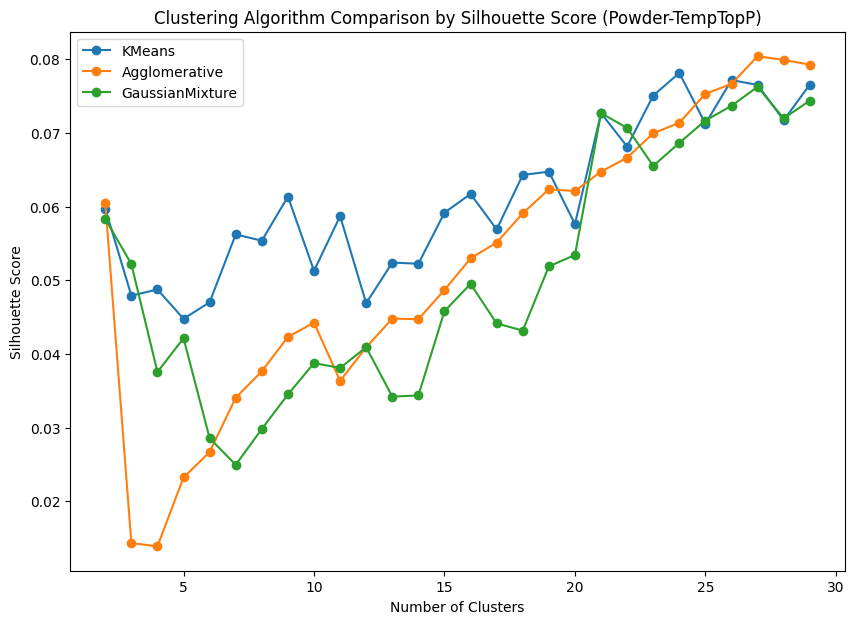

In [24]:
# Define a range of cluster numbers to evaluate
cluster_range = range(2, 30)

# Define a dictionary to store silhouette scores for each algorithm
silhouette_scores = {
    'KMeans': [],
    'Agglomerative': [],
    'GaussianMixture': []
}

# Evaluate KMeans, Agglomerative Clustering, and Gaussian Mixture Models
for n_clusters in cluster_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=3)
    kmeans_labels = kmeans.fit_predict(all_embeddings_array)
    silhouette_scores['KMeans'].append(silhouette_score(all_embeddings_array, kmeans_labels))
    
    # Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative_labels = agglomerative.fit_predict(all_embeddings_array)
    silhouette_scores['Agglomerative'].append(silhouette_score(all_embeddings_array, agglomerative_labels))
    
    # Gaussian Mixture Models
    gmm = GaussianMixture(n_components=n_clusters, random_state=3)
    gmm_labels = gmm.fit_predict(all_embeddings_array)
    silhouette_scores['GaussianMixture'].append(silhouette_score(all_embeddings_array, gmm_labels))

# Plotting the silhouette scores for each algorithm
plt.figure(figsize=(10, 7))
for algorithm, scores in silhouette_scores.items():
    plt.plot(cluster_range, scores, marker='o', label=algorithm)

# change the topic each time you run this.
plt.title('Clustering Algorithm Comparison by Silhouette Score (Powder-TempTopP)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Cluster 0: ['Human-50-v2']
Cluster 1: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-v1', 'Human-50-v2']
Cluster 2: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-v1', 'Human-50-v2']
Cluster 3: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'Human-50-v1', 'Human-50-v2']
Cluster 4: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'Human-50-v1', 'Human-50-v2']
Cluster 5: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'To

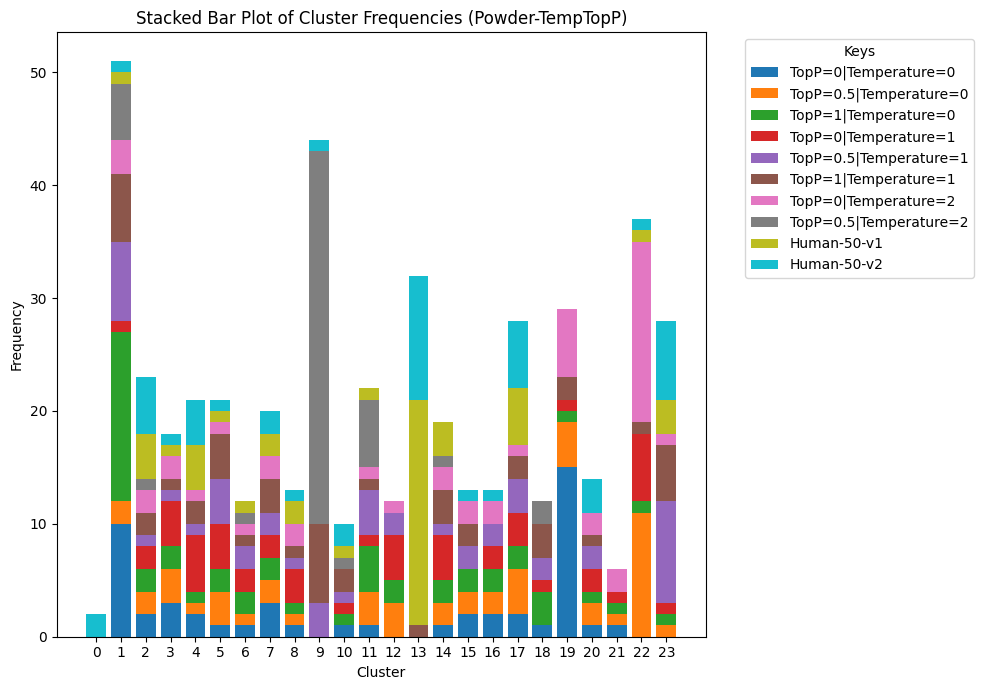

In [25]:
# List of CSV files
csv_files = [
    'data/ablation_tempTopP_powder.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)
        
# Flatten the embeddings into a single list and keep track of their column associations
all_embeddings = []
column_associations = []

for column, embeddings_list in column_embeddings.items():
    all_embeddings.extend(embeddings_list)
    column_associations.extend([column] * len(embeddings_list))

# Convert the list of embeddings into a NumPy array for clustering
# 50 solutions * 10 parameters (rows)
# 384 embeddings for each solution (columns)
all_embeddings_array = np.array(all_embeddings)

# Perform clustering
# Perform clustering on the embeddings
n_clusters = 24  # Set the number of clusters you want
kmeans = KMeans(n_clusters=n_clusters, random_state=3)
cluster_labels = kmeans.fit_predict(all_embeddings_array)

# Now, let's associate the cluster labels with their respective columns
clustered_embeddings = {
    'embeddings': all_embeddings,
    'columns': column_associations,
    'cluster_labels': cluster_labels.tolist()
}

# To analyze the clusters, let's see which columns are present in each cluster
cluster_column_associations = {i: [] for i in range(n_clusters)}

for i, label in enumerate(clustered_embeddings['cluster_labels']):
    column = clustered_embeddings['columns'][i]
    if column not in cluster_column_associations[label]:
        cluster_column_associations[label].append(column)

# Print out the column associations for each cluster
for cluster, columns in cluster_column_associations.items():
    print(f"Cluster {cluster}: {columns}")

# Optionally, you can create a DataFrame for better visualization and analysis
df_cluster_analysis = pd.DataFrame({
    'Embedding': clustered_embeddings['embeddings'],
    'Column': clustered_embeddings['columns'],
    'ClusterLabel': clustered_embeddings['cluster_labels']
})

# Count the occurrences of each column in each cluster
# we use a counter to maximize the efficiency of this process
cluster_column_counts = {}
for label, column in zip(clustered_embeddings['cluster_labels'], clustered_embeddings['columns']):
    if label not in cluster_column_counts:
        cluster_column_counts[label] = Counter()
    cluster_column_counts[label][column] += 1

# Prepare data for the stacked bar chart
cluster_bars = {}
for cluster, counts in cluster_column_counts.items():
    for column, count in counts.items():
        if column not in cluster_bars:
            cluster_bars[column] = [0] * len(cluster_column_counts)  # Initialize list for each column
        cluster_bars[column][cluster] = count
    
# Prepare the data for plotting
clusters = range(len(next(iter(cluster_bars.values()))))  # Assuming all lists are the same length
keys = cluster_bars.keys()
bottoms = [0] * len(clusters)

# Plot the stacked bar chart
plt.figure(figsize=(10, 7))  # Adjust the size as needed

for key in keys:
    values = cluster_bars[key]
    plt.bar(clusters, values, bottom=bottoms, label=key)
    bottoms = [sum(x) for x in zip(bottoms, values)]

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Stacked Bar Plot of Cluster Frequencies (Powder-TempTopP)')
plt.xticks(clusters, [i for i in clusters])
plt.legend(title='Keys', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='ClusterLabel', hover_data=['Column'], title='2D Visualization of Clustered Embeddings (Powder-TempTopP)')

# Customize the layout
fig.update_layout(
    coloraxis_colorbar=dict(title='Cluster Label'),
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2'
)

# Show the plot
fig.show()

In [27]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Define a color mapping with bold colors for 'Human-50-2v' and 'Human-50-1v', and neutral colors for others
unique_columns = df_embeddings_2d['Column'].unique()
color_mapping = {column: 'lightgrey' for column in unique_columns}  # Start with all neutral colors
color_mapping['Human-50-v1'] = 'blue'  # Assign a bold color for 'Human-50-2v'
color_mapping['Human-50-v2'] = 'red'   # Assign a bold color for 'Human-50-1v'

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='Column', hover_data=['Column', 'ClusterLabel'], title='2D Visualization of Embeddings Colored by Column (Powder-TempTopP)', color_discrete_map=color_mapping)

# Customize the layout
fig.update_layout(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Column'
)

# Show the plot
fig.show()

## Towels

In [28]:
csv_files = [
    'data/ablation_tempTopP_towels.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)

In [29]:
# Initialize an empty list to store all embeddings
all_embeddings = []

# Iterate over each column's embeddings and extend the all_embeddings list
for embeddings in column_embeddings.values():
    all_embeddings.extend(embeddings)

# Convert the list of all embeddings into a NumPy array
all_embeddings_array = np.array(all_embeddings)

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks t

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

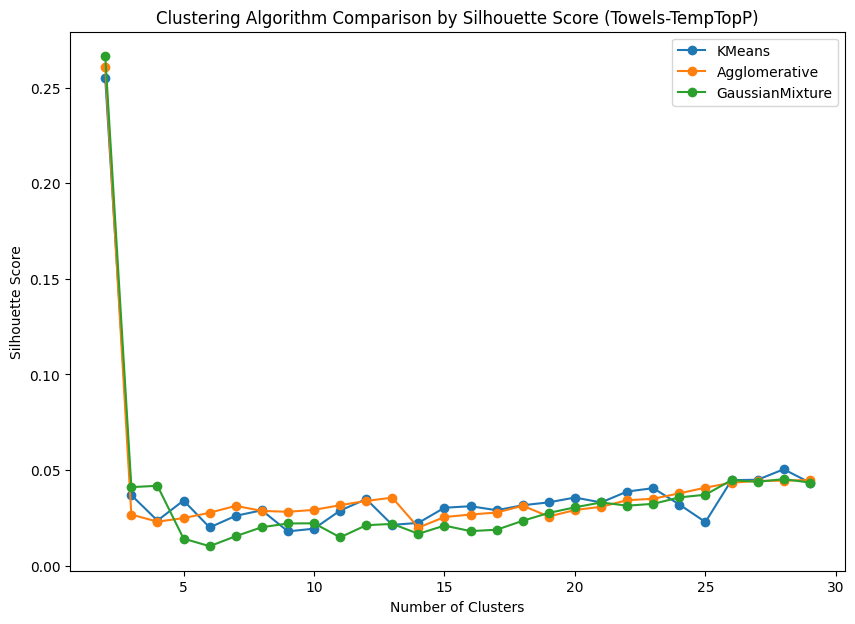

In [30]:
# Define a range of cluster numbers to evaluate
cluster_range = range(2, 30)

# Define a dictionary to store silhouette scores for each algorithm
silhouette_scores = {
    'KMeans': [],
    'Agglomerative': [],
    'GaussianMixture': []
}

# Evaluate KMeans, Agglomerative Clustering, and Gaussian Mixture Models
for n_clusters in cluster_range:
    # KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=3)
    kmeans_labels = kmeans.fit_predict(all_embeddings_array)
    silhouette_scores['KMeans'].append(silhouette_score(all_embeddings_array, kmeans_labels))
    
    # Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative_labels = agglomerative.fit_predict(all_embeddings_array)
    silhouette_scores['Agglomerative'].append(silhouette_score(all_embeddings_array, agglomerative_labels))
    
    # Gaussian Mixture Models
    gmm = GaussianMixture(n_components=n_clusters, random_state=3)
    gmm_labels = gmm.fit_predict(all_embeddings_array)
    silhouette_scores['GaussianMixture'].append(silhouette_score(all_embeddings_array, gmm_labels))

# Plotting the silhouette scores for each algorithm
plt.figure(figsize=(10, 7))
for algorithm, scores in silhouette_scores.items():
    plt.plot(cluster_range, scores, marker='o', label=algorithm)

# change the topic each time you run this.
plt.title('Clustering Algorithm Comparison by Silhouette Score (Towels-TempTopP)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\kevin\anaconda3\envs\research\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.



Cluster 0: ['TopP=0|Temperature=1', 'TopP=1|Temperature=1', 'Human-50-v1', 'Human-50-v2']
Cluster 1: ['TopP=0|Temperature=0', 'TopP=0.5|Temperature=0', 'TopP=1|Temperature=0', 'TopP=0|Temperature=1', 'TopP=0.5|Temperature=1', 'TopP=1|Temperature=1', 'TopP=0|Temperature=2', 'TopP=0.5|Temperature=2', 'Human-50-v1', 'Human-50-v2']


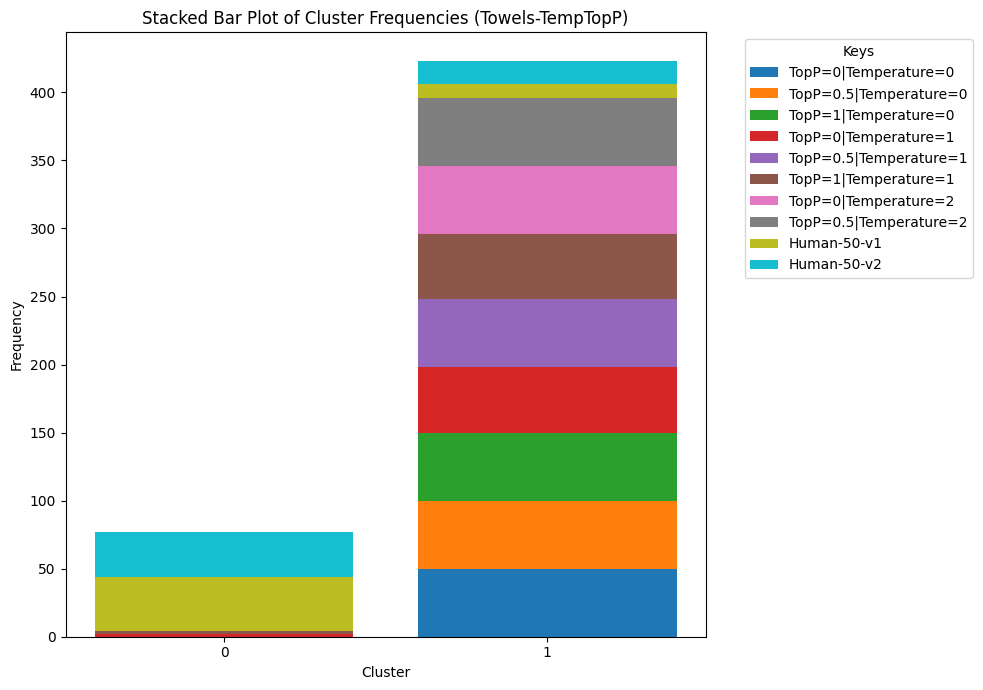

In [31]:
# List of CSV files
csv_files = [
    'data/ablation_tempTopP_towels.csv'
]

column_embeddings = {}
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    count = 0
    for column in df.columns:
        # encode the column text data into embeddings
        embeddings = model.encode(df[column].astype(str).tolist())
        if column not in column_embeddings:
            column_embeddings[column] = []
        column_embeddings[column].extend(embeddings)
        
# Flatten the embeddings into a single list and keep track of their column associations
all_embeddings = []
column_associations = []

for column, embeddings_list in column_embeddings.items():
    all_embeddings.extend(embeddings_list)
    column_associations.extend([column] * len(embeddings_list))

# Convert the list of embeddings into a NumPy array for clustering
# 50 solutions * 10 parameters (rows)
# 384 embeddings for each solution (columns)
all_embeddings_array = np.array(all_embeddings)

# Perform clustering
# Perform clustering on the embeddings
n_clusters = 2  # Set the number of clusters you want
kmeans = KMeans(n_clusters=n_clusters, random_state=3)
cluster_labels = kmeans.fit_predict(all_embeddings_array)

# Now, let's associate the cluster labels with their respective columns
clustered_embeddings = {
    'embeddings': all_embeddings,
    'columns': column_associations,
    'cluster_labels': cluster_labels.tolist()
}

# To analyze the clusters, let's see which columns are present in each cluster
cluster_column_associations = {i: [] for i in range(n_clusters)}

for i, label in enumerate(clustered_embeddings['cluster_labels']):
    column = clustered_embeddings['columns'][i]
    if column not in cluster_column_associations[label]:
        cluster_column_associations[label].append(column)

# Print out the column associations for each cluster
for cluster, columns in cluster_column_associations.items():
    print(f"Cluster {cluster}: {columns}")

# Optionally, you can create a DataFrame for better visualization and analysis
df_cluster_analysis = pd.DataFrame({
    'Embedding': clustered_embeddings['embeddings'],
    'Column': clustered_embeddings['columns'],
    'ClusterLabel': clustered_embeddings['cluster_labels']
})

# Count the occurrences of each column in each cluster
# we use a counter to maximize the efficiency of this process
cluster_column_counts = {}
for label, column in zip(clustered_embeddings['cluster_labels'], clustered_embeddings['columns']):
    if label not in cluster_column_counts:
        cluster_column_counts[label] = Counter()
    cluster_column_counts[label][column] += 1

# Prepare data for the stacked bar chart
cluster_bars = {}
for cluster, counts in cluster_column_counts.items():
    for column, count in counts.items():
        if column not in cluster_bars:
            cluster_bars[column] = [0] * len(cluster_column_counts)  # Initialize list for each column
        cluster_bars[column][cluster] = count
    
# Prepare the data for plotting
clusters = range(len(next(iter(cluster_bars.values()))))  # Assuming all lists are the same length
keys = cluster_bars.keys()
bottoms = [0] * len(clusters)

# Plot the stacked bar chart
plt.figure(figsize=(10, 7))  # Adjust the size as needed

for key in keys:
    values = cluster_bars[key]
    plt.bar(clusters, values, bottom=bottoms, label=key)
    bottoms = [sum(x) for x in zip(bottoms, values)]

plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.title('Stacked Bar Plot of Cluster Frequencies (Towels-TempTopP)')
plt.xticks(clusters, [i for i in clusters])
plt.legend(title='Keys', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

In [32]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='ClusterLabel', hover_data=['Column'], title='2D Visualization of Clustered Embeddings (Towels-TempTopP)')

# Customize the layout
fig.update_layout(
    coloraxis_colorbar=dict(title='Cluster Label'),
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2'
)

# Show the plot
fig.show()

In [33]:
# Perform PCA to reduce the embeddings to 2 dimensions
pca = PCA(n_components=2)
reduced_embeddings_2d = pca.fit_transform(all_embeddings_array)

# Create a DataFrame for the reduced embeddings with cluster labels and column names
df_embeddings_2d = pd.DataFrame(reduced_embeddings_2d, columns=['PCA1', 'PCA2'])
df_embeddings_2d['ClusterLabel'] = cluster_labels
df_embeddings_2d['Column'] = column_associations

# Define a color mapping with bold colors for 'Human-50-2v' and 'Human-50-1v', and neutral colors for others
unique_columns = df_embeddings_2d['Column'].unique()
color_mapping = {column: 'lightgrey' for column in unique_columns}  # Start with all neutral colors
color_mapping['Human-50-v1'] = 'blue'  # Assign a bold color for 'Human-50-2v'
color_mapping['Human-50-v2'] = 'red'   # Assign a bold color for 'Human-50-1v'

# Create an interactive scatter plot using Plotly Express
fig = px.scatter(df_embeddings_2d, x='PCA1', y='PCA2', color='Column', hover_data=['Column', 'ClusterLabel'], title='2D Visualization of Embeddings Colored by Column (Towels-TempTopP)', color_discrete_map=color_mapping)

# Customize the layout
fig.update_layout(
    xaxis_title='PCA Component 1',
    yaxis_title='PCA Component 2',
    legend_title='Column'
)

# Show the plot
fig.show()